### Khaled Sharafaddin - NLP Airline Tweets Sentiment Analysis - July.25.2021


#### Background and Context:

- Twitter posses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other side, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

- That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


- Listening to how customers feel about the product/services on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand, and their competitors, and discover new trends in the industry.

 

#### Data Description:

- A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## 1. Import the libraries, load dataset, the print shape of data, data description. 

In [1]:
# Libraries 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import re, string, unicodedata
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 


# 2. Airline Tweet Dataset
airlinetweets = pd.read_csv('/Users/khaledsharafaddin/Documents/Univ_Austin_Texas ML_AI/DataSets/Airline_Tweets.csv')

print('Shape of the data:', airlinetweets.shape[0],'by', airlinetweets.shape[1])
print('Description of the data: ')
airlinetweets.describe()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/khaledsharafaddin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Shape of the data: 14640 by 15
Description of the data: 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khaledsharafaddin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## 2. Understand of data columns 
- Drop all other columns except “text” and “airline_sentiment”.
- Check the shape of the data.
- Print the first 5 rows of data.

In [2]:
# a. Drop all cols except text and airline_setiment
airlines = airlinetweets.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis=1)


# b. Check the shape of the data
print('airlines Shape of the data:', airlines.shape[0],'by', airlines.shape[1])

# c. Print the first 5 rows of data.
airlines.head()

airlines Shape of the data: 14640 by 2


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## 3. Text pre-processing: Data preparation

In [3]:
# a. Html tag removal.

airlines_clean = airlines
remove_html =[]
data_size = airlines_clean.shape[0]

for i in range(0, data_size):
    remove_html.append(BeautifulSoup(airlines_clean['text'][i]).get_text())
    


In [4]:
# b. Remove the numbers, char and punctuations
remove_numbers =[]

for i in range(0, data_size):
    remove_numbers.append(re.sub("[^a-zA-Z]"," ", remove_html[i]))

In [5]:
# c. Cnversion to lower:

to_lower = []
for i in range(0, data_size):
    to_lower.append(remove_numbers[i].lower()) 


In [6]:
# d. Tokenize the list of tweets:

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

word_tokens = []
for i in range(0, data_size):
    word_tokens.append(word_tokenize(to_lower[i]))



In [7]:
# e. Remove stop words

stop_words = set(stopwords.words('english'))
remove_stopwords = []
for i in range(0, data_size):
    row = []
    for airlinetweet in word_tokens[i]:
        if airlinetweet not in stop_words:
            row.append(airlinetweet)

    remove_stopwords.append(row)
            

In [8]:
# Convert list of lists to list of strings 
tokenized_tweets = [' '.join(my_list) for my_list in remove_stopwords]

In [9]:
# f. lemmatize text:
from nltk.stem.wordnet import WordNetLemmatizer 
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

lemmatize_text = []

for i in range(0, data_size):
     lemmatize_text.append(lemmatizer.lemmatize((tokenized_tweets[i])))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/khaledsharafaddin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# g. Join the words in the list to convert back to text string in the data frame.

cleaned_tweets = pd.DataFrame(
{
    'Airline_sentiment': airlines_clean['airline_sentiment'], 
    'Tweet_Text': lemmatize_text
})

# Copy to create word cloud before hot encoding the sentiment to numbers 
word_cloud_sentiment = cleaned_tweets


In [11]:
# h. Replace Airline_sentiment with dummy variables (encoding)

cleaned_tweets["Airline_sentiment"].replace({"neutral": 0, "positive": 1, "negative":2}, inplace=True)

# i. Print the first 5 rows of data after pre-processing.

cleaned_tweets.head()

,Airline_sentiment,Tweet_Text
0,0,virginamerica dhepburn said
1,1,virginamerica plus added commercials experienc...
2,0,virginamerica today must mean need take anothe...
3,2,virginamerica really aggressive blast obnoxiou...
4,2,virginamerica really big bad thing


## 4. Vectorization:

In [12]:
# a. CountVectorizer: 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
Tweets_vectorizer = CountVectorizer()
tweets_list = list(cleaned_tweets['Tweet_Text'])
vectorized_tweets = Tweets_vectorizer.fit_transform(cleaned_tweets['Tweet_Text']) 
vectorized_tweets = vectorized_tweets.toarray() 

print('CountVectorizer Shape:', vectorized_tweets.shape)

# --------------------------

# b. TfidfVectorizer
Tweets_TfidfVectorizer = TfidfVectorizer()

# tokenize and build vocab
Tweets_TfidfVectorizer.fit(cleaned_tweets['Tweet_Text'])

#summarize
print('Inverse Document Victorizer Frequencies: \n')
print(Tweets_TfidfVectorizer.idf_)


# encode document
TfidfVectorizer = Tweets_TfidfVectorizer.transform(cleaned_tweets['Tweet_Text']).toarray()

# summarize encoded vector
print('\nTfidfVectorizer Shape:', TfidfVectorizer.shape)


CountVectorizer Shape: (14640, 13493)


TfidfVectorizer()

Inverse Document Victorizer Frequencies: 

[4.98577902 9.89843391 9.89843391 ... 9.89843391 9.89843391 9.89843391]

TfidfVectorizer Shape: (14640, 13493)


## 5. Fit and evaluate the model using both types of vectorization

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# 5. Using random forest classifier for CountVectorizer


rf = RandomForestClassifier(n_estimators=10, n_jobs=4)
print('Training the random forest on CountVectorizer...')

X = vectorized_tweets
y = cleaned_tweets['Airline_sentiment']



# Split to train and test sets: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1)

# Fit the model
rf = rf.fit(X_train, y_train)
rf
print("Accuracy on training set : ",rf.score(X_train, y_train))
print("Accuracy on test set : ",rf.score(X_test, y_test))


Training the random forest on CountVectorizer...


RandomForestClassifier(n_estimators=10, n_jobs=4)

Accuracy on training set :  0.9844847775175644
Accuracy on test set :  0.7363387978142076


Text(0.5, 15.0, 'True labels')

Text(33.0, 0.5, 'Predicted labels')

Text(0.5, 1, 'Confusion Matrix')

[Text(0.5, 0, '0'), Text(1.5, 0, '1'), Text(2.5, 0, '2')]

[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]


 precision and recall: 

              precision    recall  f1-score   support

           0       0.54      0.51      0.53       936
           1       0.68      0.54      0.60       715
           2       0.80      0.86      0.83      2741

    accuracy                           0.74      4392
   macro avg       0.68      0.64      0.66      4392
weighted avg       0.73      0.74      0.73      4392



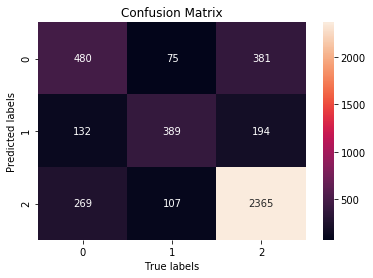

In [14]:
# Predict X_test and print Confusion Matrix:

from sklearn import metrics

vect_predict = rf.predict(X_test)    

ax= plt.subplot()
lebels = [0,1,2]
cm = confusion_matrix(y_test, vect_predict, lebels)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0,1,2]); ax.yaxis.set_ticklabels([0,1,2]);


# Printing the precision and recall, among other metrics
print('\n precision and recall: \n')
print(metrics.classification_report(y_test, vect_predict, labels=[0, 1, 2]))

In [15]:
# Create random Forest Classifier
rf2 = RandomForestClassifier(n_estimators=10, n_jobs=4)
print('Training the random forest on TfidfVectorizer...')

# Get the train sets: 
X = TfidfVectorizer
y = cleaned_tweets['Airline_sentiment']

# Fit the model
rf2 = rf2.fit(X, y)
rf2

# We perform k-fold cross validation with 10 folds
# The model trains on K-1 (9) folds, and uses the 10th fold for testing accuracy. 
# This is repeated 10 times, then we take the avrage of the accuracy score of all 10 folds

cv_avg_accuracy = round(np.mean(cross_val_score(rf2, X, y, cv=10)),2)
print('Mean Cross Validation Accuracy for TfidfVectorizer:', cv_avg_accuracy*100, '%')

Training the random forest on TfidfVectorizer...


RandomForestClassifier(n_estimators=10, n_jobs=4)

Mean Cross Validation Accuracy for TfidfVectorizer: 70.0 %


In [43]:
# # Word cloud for positive sentiment

Positive_sent = word_cloud_sentiment[word_cloud_sentiment['Airline_sentiment']=='positive']
Negative_sent = word_cloud_sentiment[word_cloud_sentiment['Airline_sentiment']=='negative']
Neutral_sent = word_cloud_sentiment[word_cloud_sentiment['Airline_sentiment']=='neutral']

import wordcloud
def show_wordcloud(Positive_sent, title):
    text = ' '.join(Positive_sent['content'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()
    

(-0.5, 399.5, 199.5, -0.5)

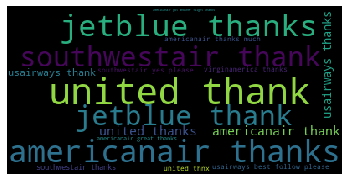

In [29]:
# Positive Airline Tweets: 
data = Positive_sent['Tweet_Text'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data)

plt.imshow(wc)
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

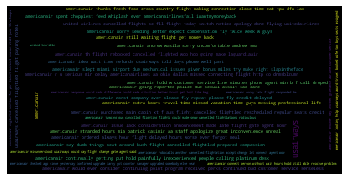

In [36]:
# Negative Airline Tweets: 
data = Negative_sent['Tweet_Text'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data)

plt.imshow(wc)
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

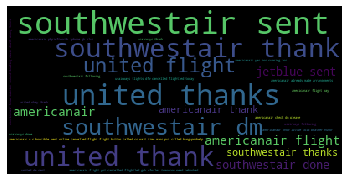

In [41]:
# Neutral Airline Tweets: 
data = Neutral_sent['Tweet_Text'].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data)

plt.imshow(wc)
plt.axis('off')
plt.show()

### Summary
- The airline tweet dataset contains 14640 rows and 15 columns that has customer reviews of airline services including United, American airllines, Southwest. 

- The reviews are categorized into Positive, Negative or Neutral Sentiments. 

- The purpose of this project is to test whether a customer review is positive, negative or neutral, using a machine learning classification algorithm.

- Before applying the dataset into ML algorithm, data pre-processing steps have been taken, including: 
    1. Removing HTML tags
    2. Remove numbers and special characters
    3. convert text to lower case
    4. Stop words removal
    5. Tokenization and stemming
 
 
- Random Forest is used to determine the category of the review, achieving 74% accuracy. 

- Confusion Matrix is created, proving important metrics such as precision, recall and F score. 

- Wordcloud has been generated to see the most frequent words used in the reviews. 
- Positive words include thank you, great, and love.
- Negative sentiments include cancelled, bad, and worst.
- Neutral sentiments include americanair, usairways and southwestair, which don't provide analytical value. 

- The sentiment analysis model can be imporved further using Neural Networks, or ensemble methods to increase accuracy of sentiment prediction.  